# Notebook to demonstrate the filtering process for the Pallas stream DTS data

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
from utils import read_fmi_meteo_obs, plot_2D_dts_colormap, histogram_match, plot_dts_meteo_distributions

## Reading the DTS data (xr dataset) and air temperature observations (pd dataframe)

In [2]:
file = '/Users/jpnousu/DTS_data/PROCESSED_DATA/pallas_dts_data_new.nc'
data = xr.open_dataset(file)

<Axes: xlabel='time'>

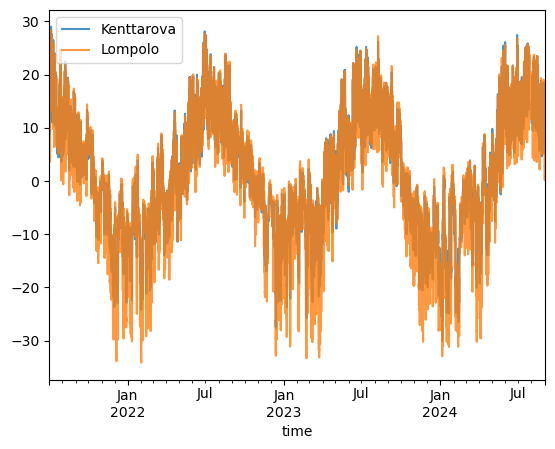

In [3]:
meteo_file1 = r'/Users/jpnousu/DTS_data/AUX_DATA/Kittilä Kenttärova_ 1.7.2021 - 2.9.2024_c07c2c96-089c-4173-9cd0-e58fe8386405.csv'
meteo_file2 = r'/Users/jpnousu/DTS_data/AUX_DATA/Kittilä Lompolonvuoma_ 1.7.2021 - 2.9.2024_d72a1f1a-216a-4333-879e-c59da03528b7.csv'

meteo1 = read_fmi_meteo_obs(filename=meteo_file1, resample='30MIN')
meteo2 = read_fmi_meteo_obs(filename=meteo_file2, resample='30MIN')

meteo1 = meteo1.rename(columns={'Tair': 'Kenttarova'})
meteo2 = meteo2.rename(columns={'Tair': 'Lompolo'})
meteo1['Lompolo'] = meteo2['Lompolo']

meteo1.plot(alpha=0.8)

## #1 Checking for clear erroneous timesteps in DTS data

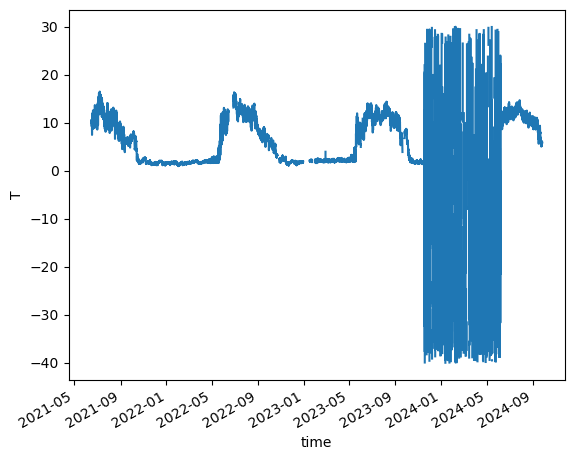

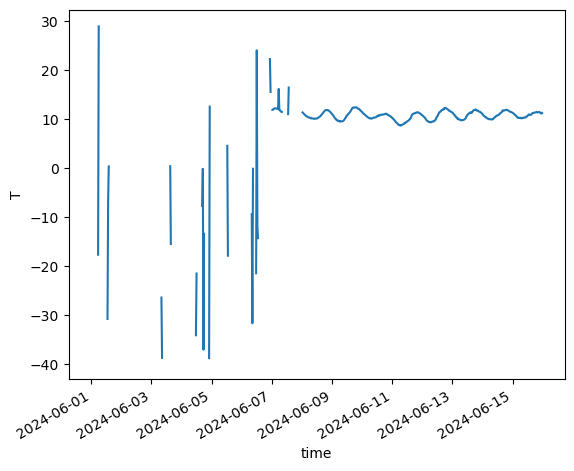

In [4]:
plt.figure(1)
data['T'].mean(dim='x').plot()
plt.figure(2)
data['T'].sel(time=slice('2023-11-01', None)).mean(dim='x').plot()
plt.figure(3)
data['T'].sel(time=slice('2024-06-01', '2024-06-15')).mean(dim='x').plot()

### Removing the dates after 2023-11-15

In [5]:
# Define the time range to set as NaN
mask_time = slice("2023-11-15", "2024-06-09")

# Assign NaN to 'T' in the selected time range
data['T'].loc[dict(time=mask_time)] = np.nan

#data = data.sel(time=slice(None, "2023-11-15"))

## #2 Searching where the cable is out of water
### Are there extreme negative sections during winter? Yes.

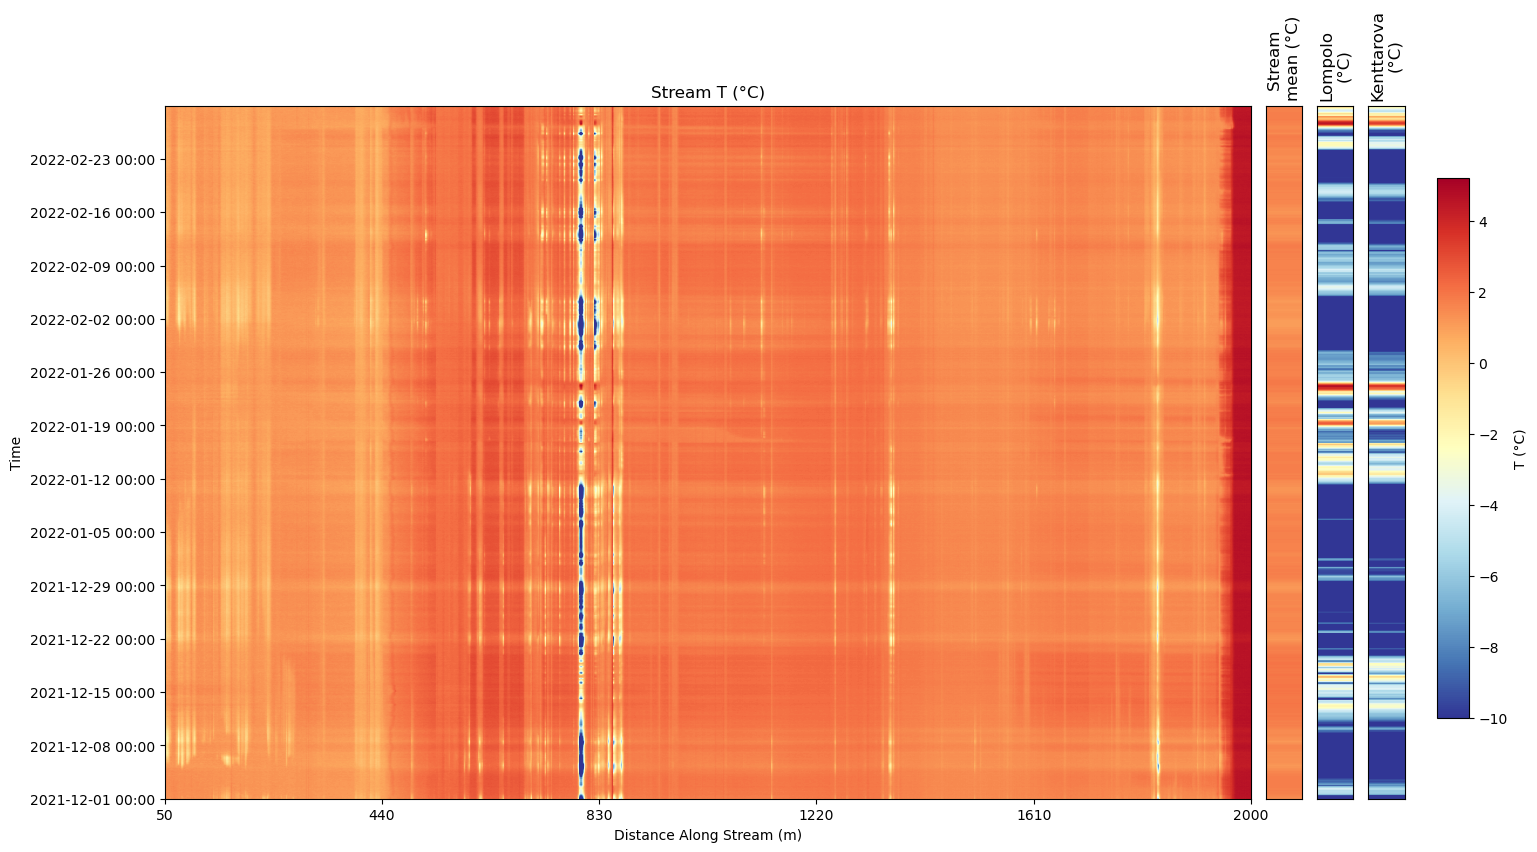

In [6]:
time_slice = slice('2021-12-01', '2022-03-01')
x_slice = slice(50, 2000)
plot_2D_dts_colormap(xr_data=data, meteo_df=meteo1, vmin=-10, time_slice=time_slice, x_slice=x_slice)

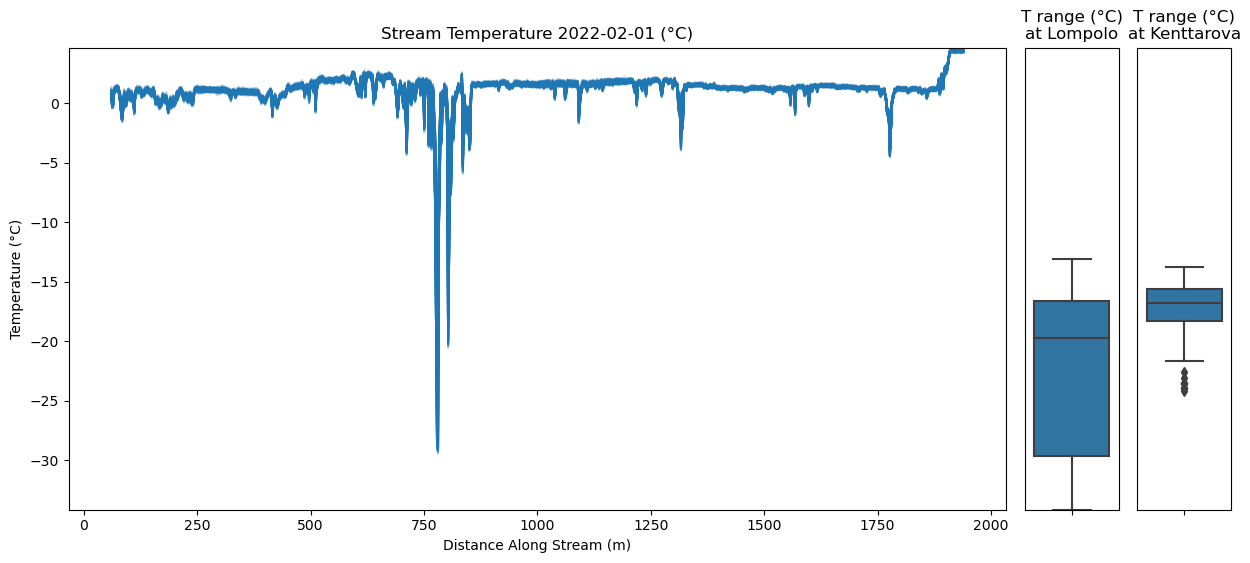

In [7]:
time_slice = slice('2022-02-01', '2022-02-02')
x_slice = slice(50, 2000)

plot_dts_meteo_distributions(xr_data=data, meteo_df=meteo1, time_slice=time_slice, x_slice=x_slice, save_fp=None)

### Are there sections where the summertime diurnal variation is close to observed air temperature? Yes.

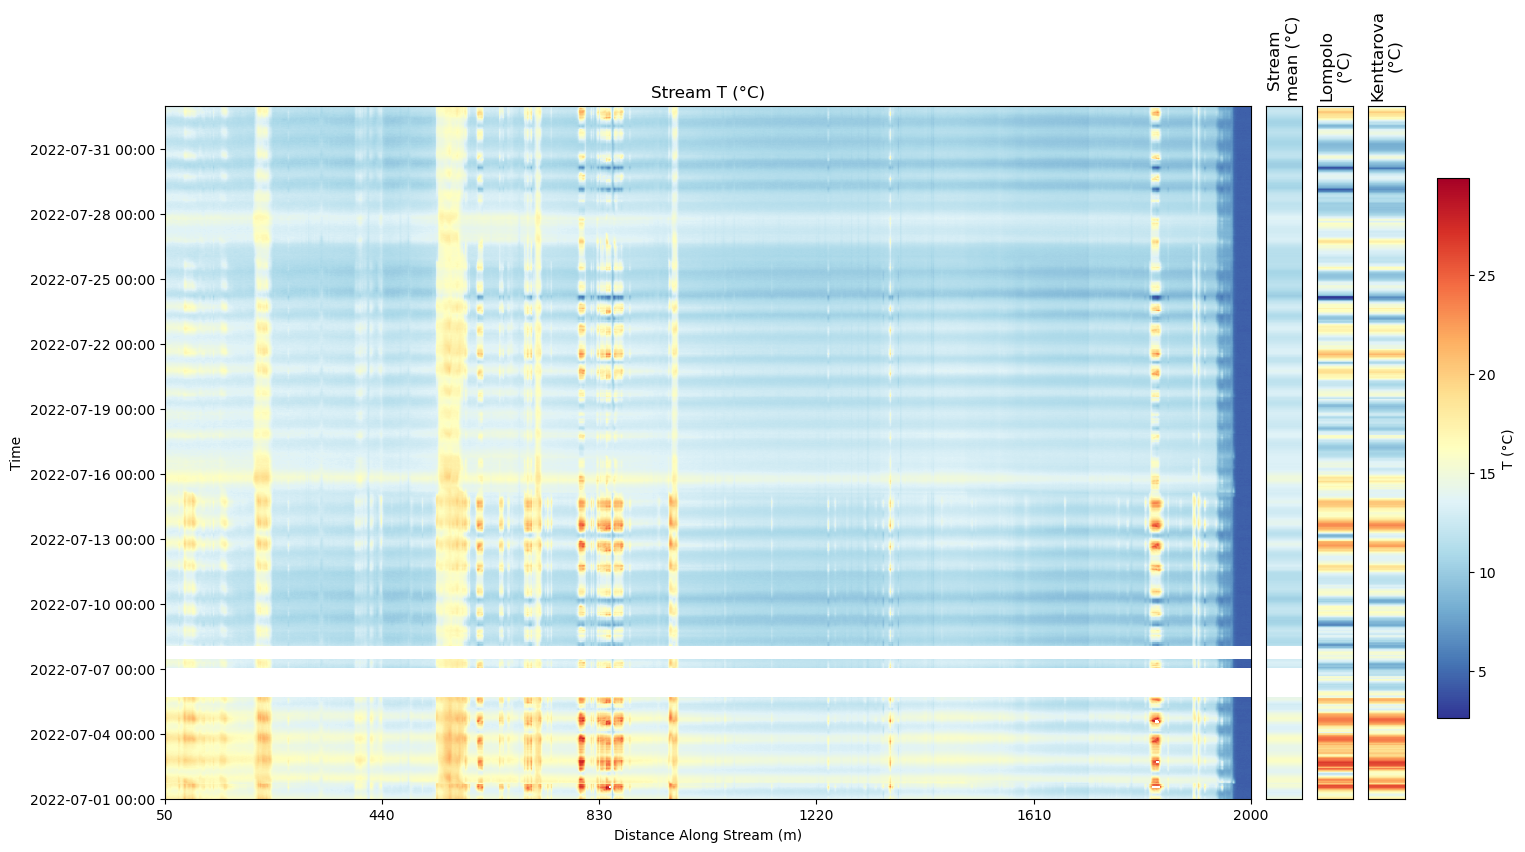

In [8]:
time_slice = slice('2022-07-01', '2022-08-01')
x_slice = slice(50, 2000)
plot_2D_dts_colormap(xr_data=data, meteo_df=meteo1, time_slice=time_slice, x_slice=x_slice)

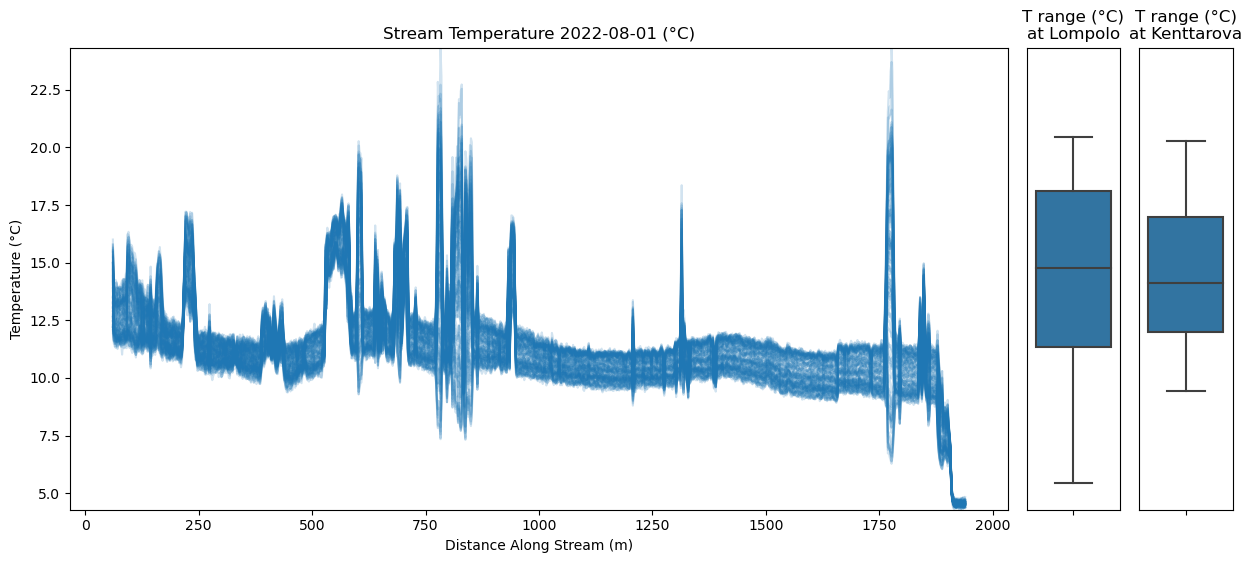

In [9]:
time_slice = slice('2022-08-01', '2022-08-02')
x_slice = slice(50, 2000)

plot_dts_meteo_distributions(xr_data=data, meteo_df=meteo1, time_slice=time_slice, x_slice=x_slice, save_fp=None)

### Removing the data locations (x) where at least 5% of the data is negative

In [10]:
# Deep copy of the dataset
f_data = data.copy(deep=True)

# Compute the 5% quantile along 'time' for each x location (drop the 'quantile' coordinate)
quantile = data["T"].quantile(0.05, dim="time").drop_vars("quantile")

# Build a mask of x locations where the 5% quantile is below 0
mask = quantile < 0  # shape: (x,)

# Expand this mask to align with (time, x) shape of 'T'
mask_broadcasted = mask.broadcast_like(data["T"])

# Apply the mask
f_data["T"] = data["T"].where(~mask_broadcasted)

# Copy of the data for filtering
#f_data = data.copy(deep=True)

# Compute the quantile along the time dimension
#quantile = data["T"].quantile(0.05, dim="time")

# Identify locations where the quantile is below 0
#mask = quantile < 0

# Replace all values at those locations with NaN
#f_data["T"] = data["T"].where(~mask, np.nan)

#### Plotting the same figures to see if the filtering worked

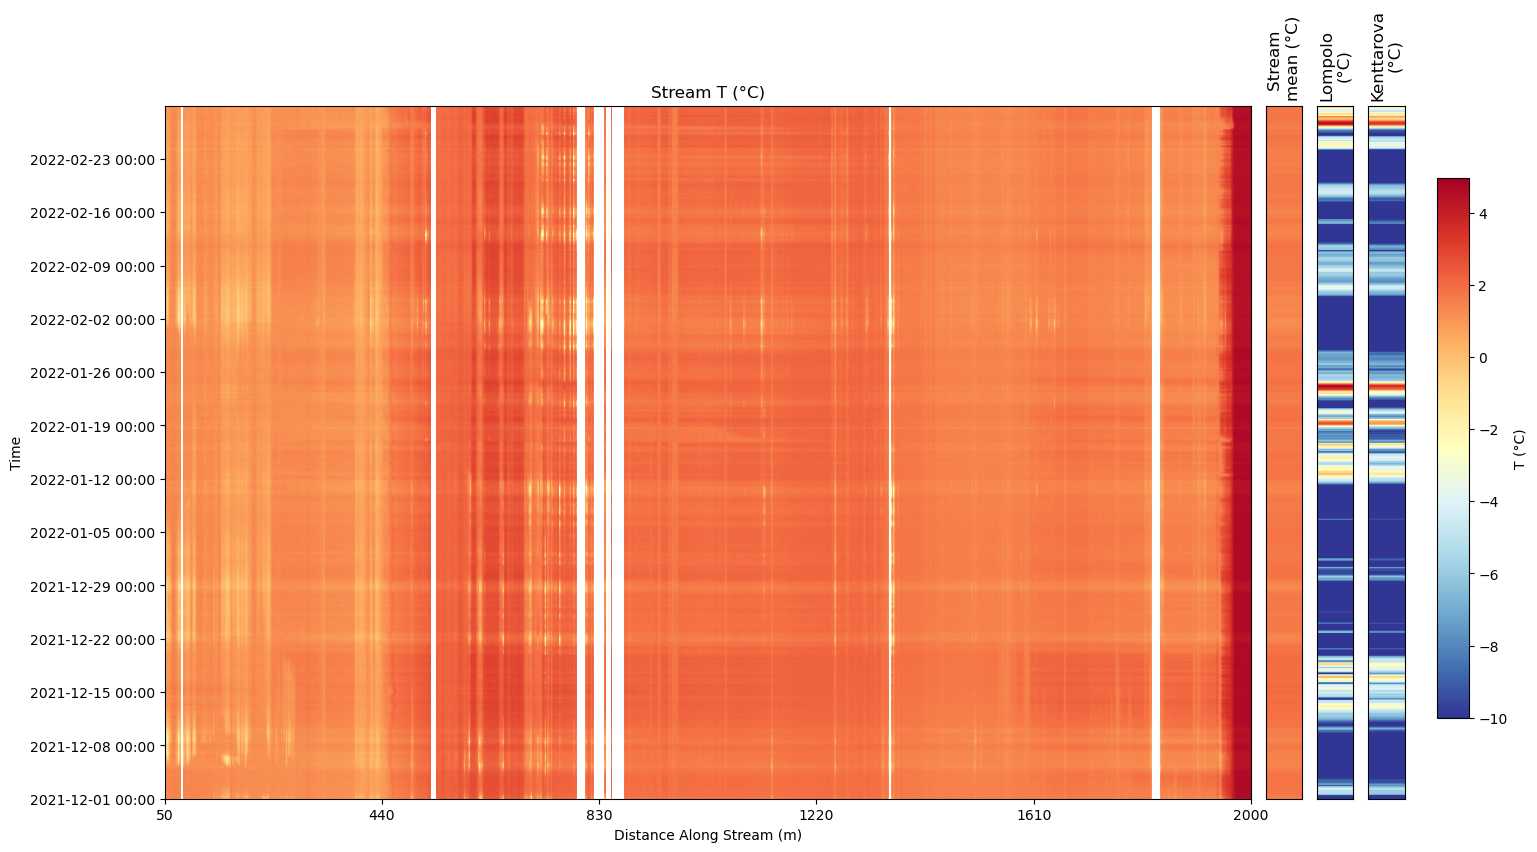

In [11]:
time_slice = slice('2021-12-01', '2022-03-01')
x_slice = slice(50, 2000)

plot_2D_dts_colormap(xr_data=f_data, meteo_df=meteo1, vmin=-10, time_slice=time_slice, x_slice=x_slice)

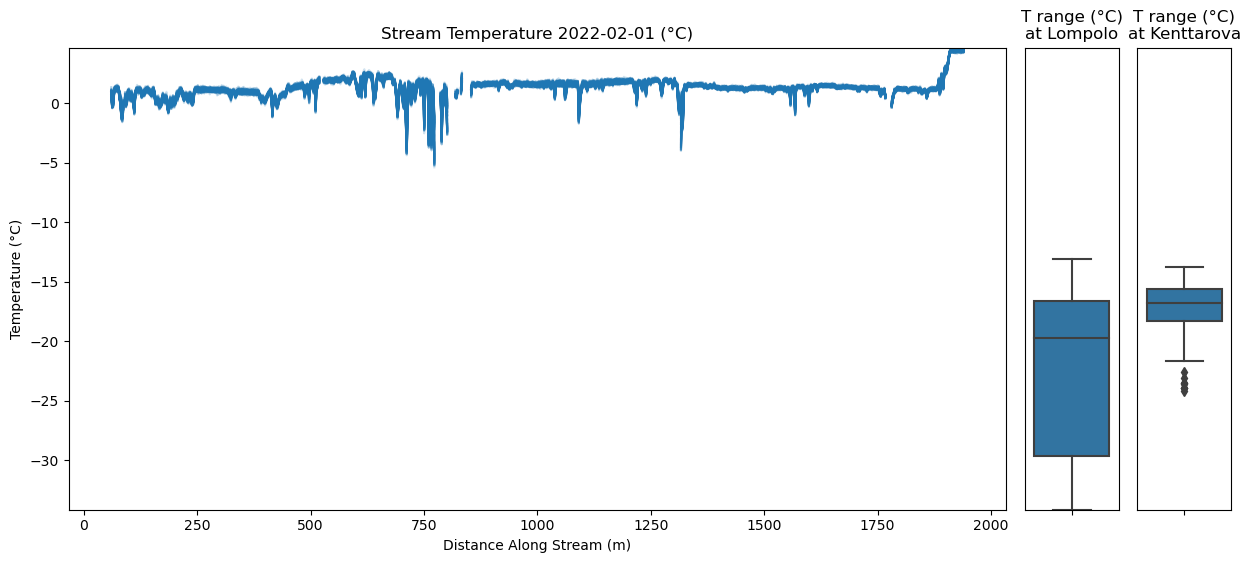

In [12]:
time_slice = slice('2022-02-01', '2022-02-02')
x_slice = slice(50, 2000)

plot_dts_meteo_distributions(xr_data=f_data, meteo_df=meteo1, time_slice=time_slice, x_slice=x_slice, save_fp=None)

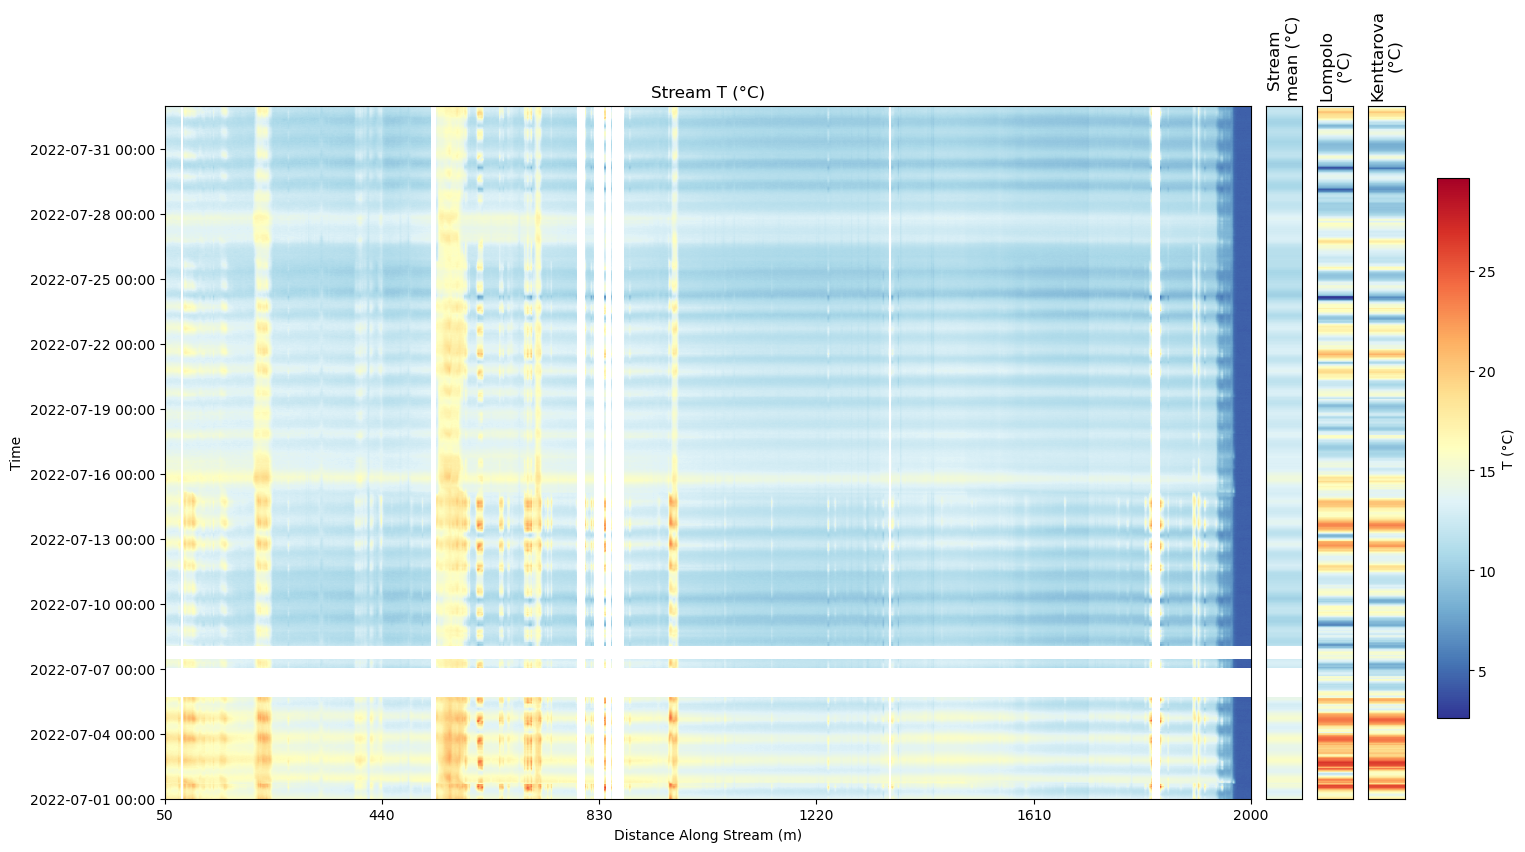

In [13]:
time_slice = slice('2022-07-01', '2022-08-01')
x_slice = slice(50, 2000)
plot_2D_dts_colormap(xr_data=f_data, meteo_df=meteo1, time_slice=time_slice, x_slice=x_slice)

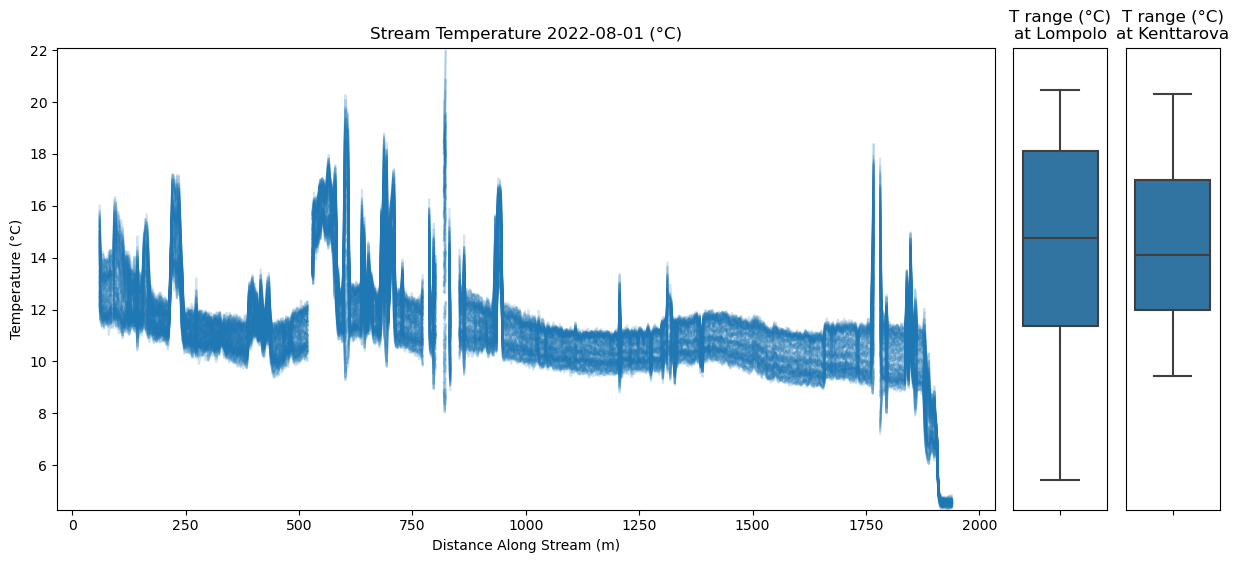

In [14]:
time_slice = slice('2022-08-01', '2022-08-02')
x_slice = slice(50, 2000)

plot_dts_meteo_distributions(xr_data=f_data, meteo_df=meteo1, time_slice=time_slice, x_slice=x_slice, save_fp=None)

### Filtering worked mostly, but it seems that there are still DTS sections where summer diurnal variations are close to air temperature
#### For example here

In [15]:
time_slice = slice('2022-06-08', '2022-06-10')
x_slice = slice(200, 1000)
plot_2D_dts_colormap(xr_data=f_data, meteo_df=meteo1, time_slice=time_slice, x_slice=x_slice)

#### Subsetting for summer months and common dates

In [16]:
f_filtered = f_data.where((f_data.time.dt.month > 5) & (f_data.time.dt.month < 9), drop=True)

# Find common times
common_times = meteo1.index.intersection(f_filtered.time.values)

# Subset both datasets to only include common times
f_filtered = f_filtered.sel(time=common_times)
meteo1_filtered = meteo1.loc[common_times]

### Example distributions in summer
#### Close to air temperature distributions

In [17]:
x_temp = 602.397

#plt.hist(meteo1.loc[(meteo1.index.month > 5) & (meteo1.index.month < 9), 'Lompolo'], bins=50, alpha=0.5, label='Lompolo')
plt.hist(meteo1.loc[(meteo1.index.month > 5) & (meteo1.index.month < 9), 'Kenttarova'], bins=50, alpha=0.5, label='Kenttarova')
plt.hist(f_filtered.sel(x=x_temp)['T'], bins=50, alpha=0.5, label='DTS')
hm_temp = histogram_match(np.array(f_filtered.sel(x=x_temp)['T']), np.array(meteo1_filtered['Kenttarova']), lims=[0,30])
plt.title(f'X = {x_temp}, histogram match = {hm_temp}')
plt.legend()

#### More realistic compared to air temperature distributions

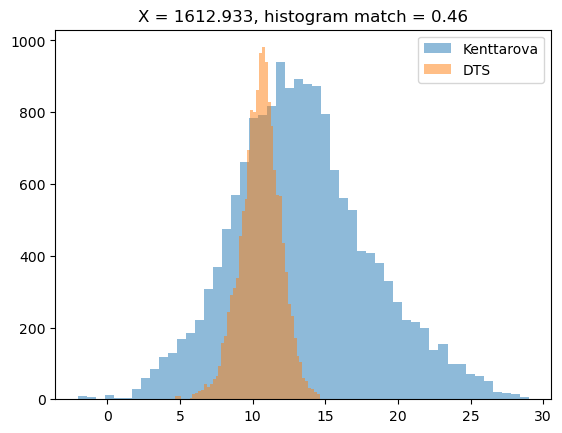

In [18]:
x_temp = 1612.933

#plt.hist(meteo1.loc[(meteo1.index.month > 5) & (meteo1.index.month < 9), 'Lompolo'], bins=50, alpha=0.5, label='Lompolo')
plt.hist(meteo1.loc[(meteo1.index.month > 5) & (meteo1.index.month < 9), 'Kenttarova'], bins=50, alpha=0.5, label='Kenttarova')
plt.hist(f_filtered.sel(x=x_temp)['T'], bins=50, alpha=0.5, label='DTS')
hm_temp = histogram_match(np.array(f_filtered.sel(x=x_temp)['T']), np.array(meteo1_filtered['Kenttarova']), lims=[0,30])
plt.title(f'X = {x_temp}, histogram match = {hm_temp}')
plt.legend()

#### Calculating and plotting histogram match for all the x's

In [19]:
hm = pd.DataFrame(index=f_filtered['x'].values, columns=['hm1', 'hm2'])

for x in hm.index:
    hm.at[x, 'hm1'] = histogram_match(np.array(f_filtered.sel(x=x)['T']), np.array(meteo1_filtered['Lompolo']), lims=[0,30])
    hm.at[x, 'hm2'] = histogram_match(np.array(f_filtered.sel(x=x)['T']), np.array(meteo1_filtered['Kenttarova']), lims=[0,30])

/Users/jpnousu/DTS_tools/utils.py:340: RuntimeWarning: invalid value encountered in scalar divide
  gamma = round(np.sum(minima)/np.sum(hobs),2)


Text(0.5, 0, 'Distance along stream [m]')

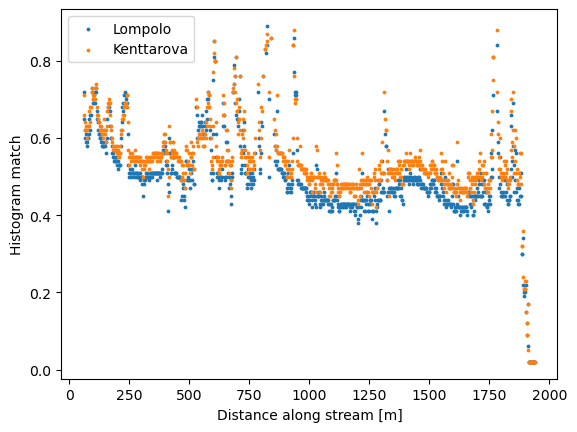

In [20]:
plt.scatter(hm.index, hm['hm1'], s=3, label='Lompolo')
plt.scatter(hm.index, hm['hm2'], s=3, label='Kenttarova')
plt.legend()
plt.ylabel('Histogram match')
plt.xlabel('Distance along stream [m]')

### Filtering those x's that have high histogram match

In [21]:
f_data_2 = f_data.copy(deep=True)
hm_lim = 0.7

filter_xs = np.array(hm.loc[(hm['hm1'] > hm_lim) | (hm['hm2'] > hm_lim)].index)
filter_xs_set = set(filter_xs)
f_data_2['T'] = xr.where(np.isin(f_data_2['x'], list(filter_xs_set)), np.nan, f_data_2['T'])

### Once again a bit better data but in some locations DTS shows much higher temperatures than meteorological observations

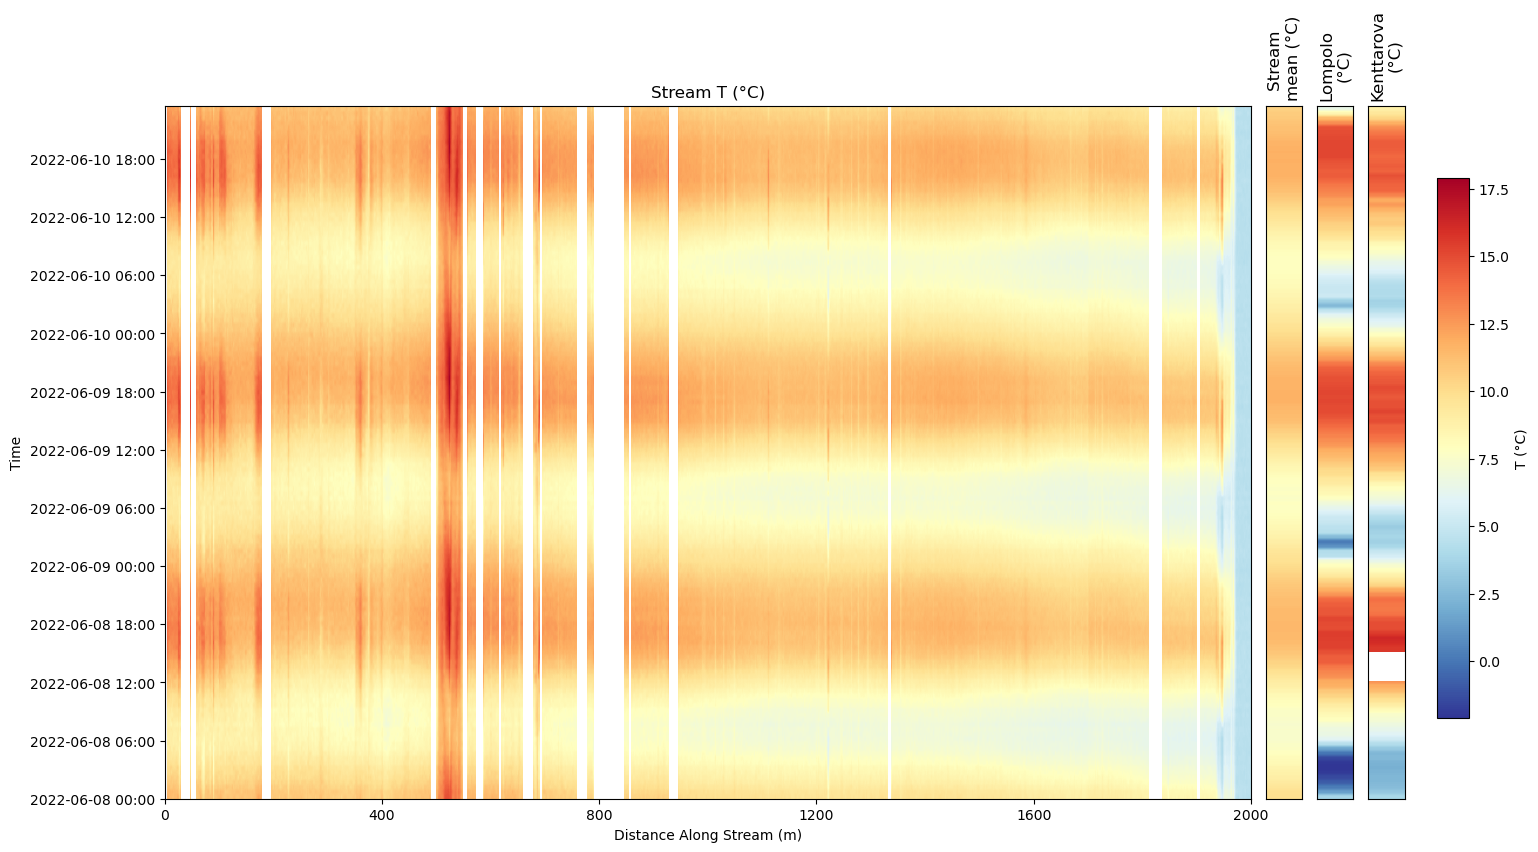

In [22]:
time_slice = slice('2022-06-08', '2022-06-10')
x_slice = slice(0, 2000)
plot_2D_dts_colormap(xr_data=f_data_2, meteo_df=meteo1, time_slice=time_slice, x_slice=x_slice)

## #3 Finding DTS sections where summer temperatures are unrealistically high
#### Subsetting for summer months and common dates

In [23]:
f_filtered_2 = f_data_2.where((f_data_2.time.dt.month > 5) & (f_data_2.time.dt.month < 9), drop=True)

# Find common times
common_times = meteo1.index.intersection(f_filtered_2.time.values)

# Subset both datasets to only include common times
f_filtered_2 = f_filtered_2.sel(time=common_times)
meteo1_filtered_2 = meteo1.loc[common_times]

#### Example distribution of way too high DTS temperature

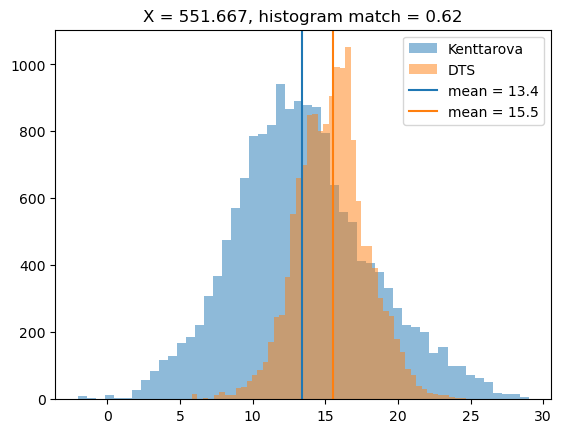

In [24]:
x_temp = 551.667

#plt.hist(meteo1.loc[(meteo1.index.month > 5) & (meteo1.index.month < 9), 'Lompolo'], bins=50, alpha=0.5, label='Lompolo')
plt.hist(meteo1.loc[(meteo1.index.month > 5) & (meteo1.index.month < 9), 'Kenttarova'], bins=50, alpha=0.5, label='Kenttarova')
plt.hist(f_filtered_2.sel(x=x_temp)['T'], bins=50, alpha=0.5, label='DTS')
hm_temp = histogram_match(np.array(f_filtered_2.sel(x=x_temp)['T']), np.array(meteo1_filtered['Kenttarova']), lims=[0,30])
meteo_mean = round(meteo1.loc[(meteo1.index.month > 5) & (meteo1.index.month < 9), 'Kenttarova'].mean(),1)
dts_mean = round(np.nanmean(f_filtered_2.sel(x=x_temp)['T']), 1)
plt.axvline(meteo_mean, color='tab:blue', linestyle='-', label=f'mean = {meteo_mean}')
plt.axvline(dts_mean, color='tab:orange', linestyle='-', label=f'mean = {dts_mean}')
plt.title(f'X = {x_temp}, histogram match = {hm_temp}')
plt.legend()

#### Calculating and plotting summertime means for all x's and meteorological observations

/var/folders/01/f14lxpfj5wl28zjtf5rz8t9c0000gn/T/ipykernel_15561/2664176285.py:6: RuntimeWarning: Mean of empty slice
  means.at[x, 'dts_mean'] = np.nanmean(f_filtered_2.sel(x=x)['T'])


<Axes: >

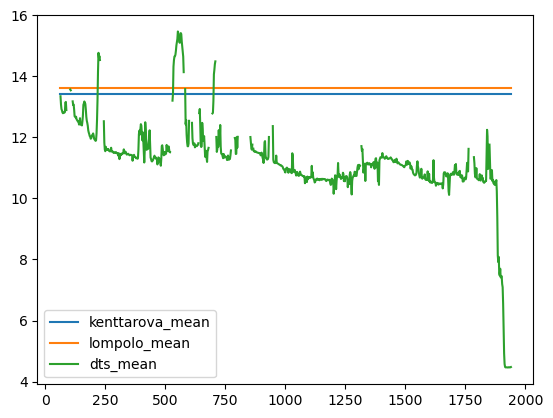

In [25]:
means = pd.DataFrame(index=f_filtered['x'].values, columns=['kenttarova_mean', 'lompolo_mean', 'dts_mean'])

for x in means.index:
    means.at[x, 'kenttarova_mean'] = np.nanmean(meteo1_filtered_2['Kenttarova'])
    means.at[x, 'lompolo_mean'] = np.nanmean(meteo1_filtered_2['Lompolo'])
    means.at[x, 'dts_mean'] = np.nanmean(f_filtered_2.sel(x=x)['T'])
means.plot()

#### Filtering those x's that have higher mean than that of air

In [26]:
f_data_3 = f_data_2.copy(deep=True)

filter_xs_2 = np.array(means.loc[((means['dts_mean'] > means['lompolo_mean']) | 
                                  (means['dts_mean'] > means['kenttarova_mean']))].index)
filter_xs_set_2 = set(filter_xs_2)
f_data_3['T'] = xr.where(np.isin(f_data_3['x'], list(filter_xs_set_2)), np.nan, f_data_3['T'])

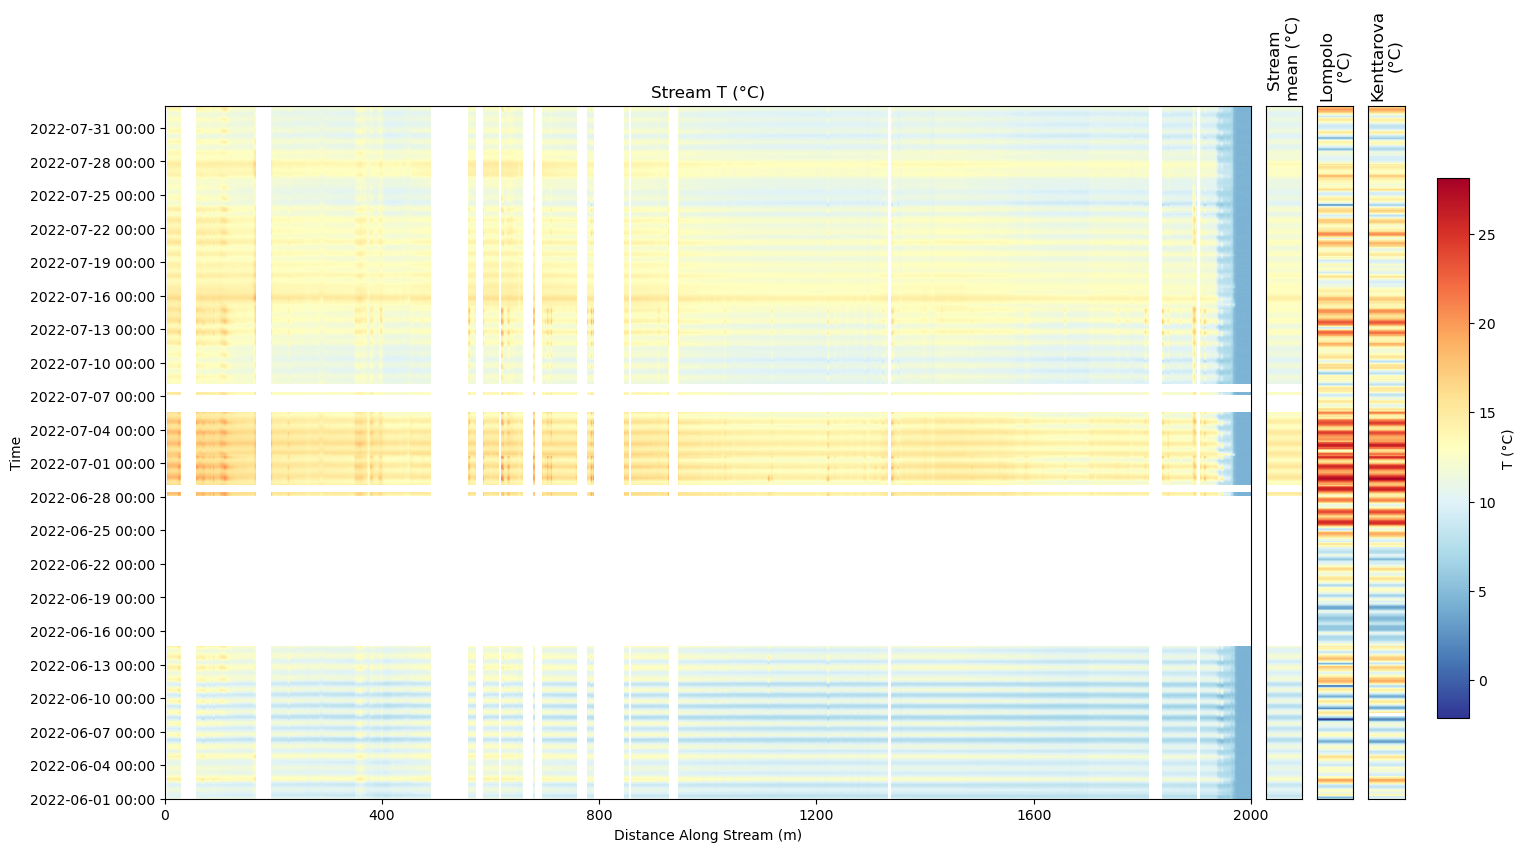

In [27]:
time_slice = slice('2022-06-01', '2022-08-01')
x_slice = slice(0, 2000)
plot_2D_dts_colormap(xr_data=f_data_3, meteo_df=meteo1, time_slice=time_slice, x_slice=x_slice)

In [28]:
time_slice = slice('2022-08-01', '2022-08-02')
x_slice = slice(50, 2000)

plot_dts_meteo_distributions(xr_data=f_data_3, meteo_df=meteo1, time_slice=time_slice, x_slice=x_slice, save_fp=None)

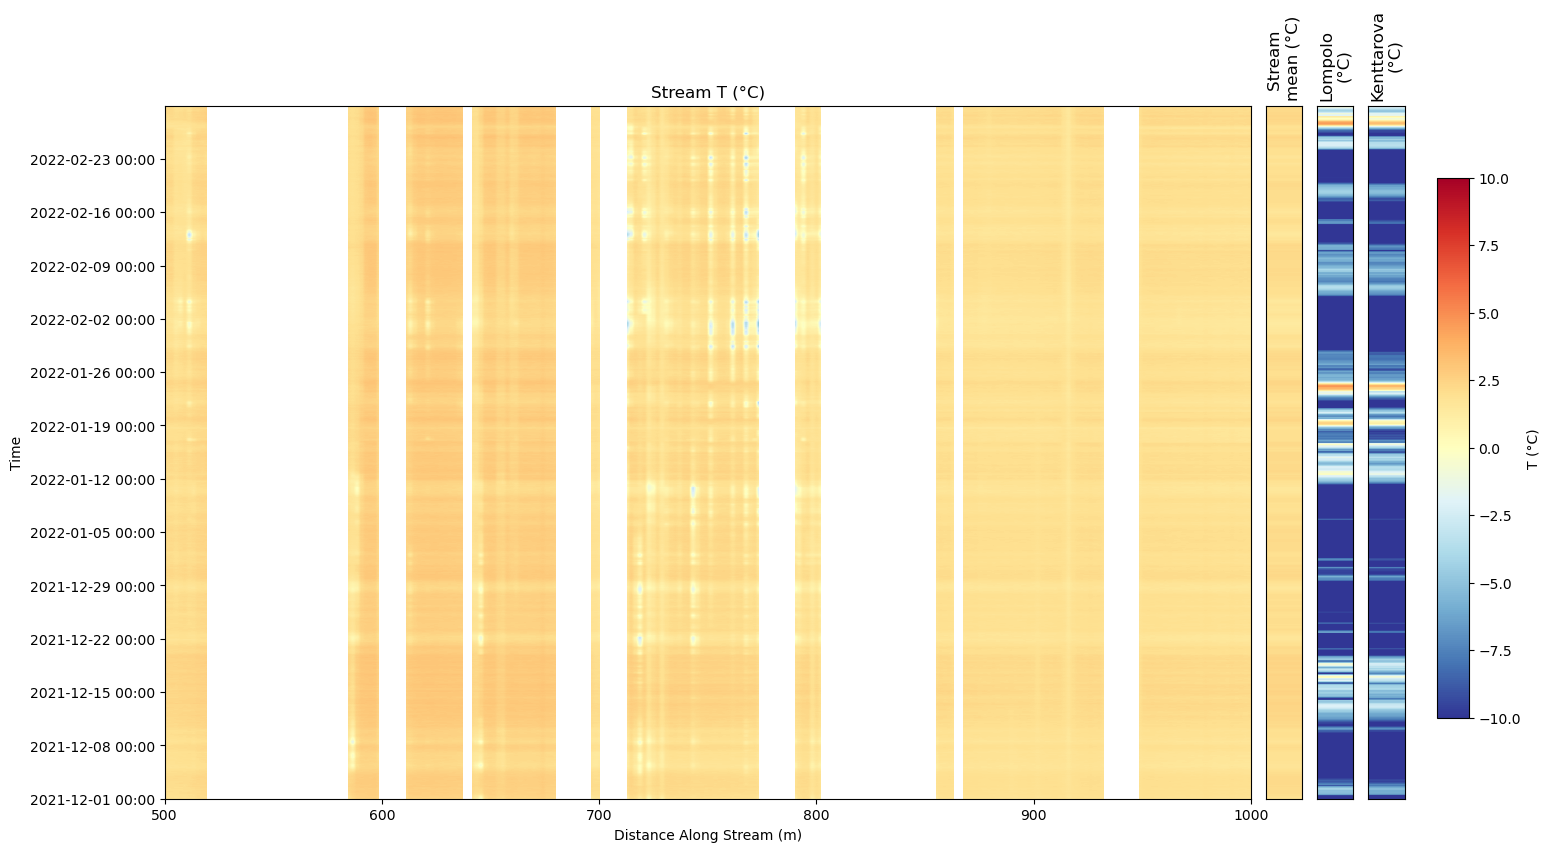

In [29]:
time_slice = slice('2021-12-01', '2022-03-01')
x_slice = slice(500, 1000)
plot_2D_dts_colormap(xr_data=f_data_3, meteo_df=meteo1, time_slice=time_slice, vmin=-10, vmax=10, x_slice=x_slice)

In [30]:
time_slice = slice('2022-02-01', '2022-02-02')
x_slice = slice(50, 2000)

plot_dts_meteo_distributions(xr_data=f_data_3, meteo_df=meteo1, time_slice=time_slice, x_slice=x_slice, save_fp=None)

### Looks pretty OK now although there are still some frozen sections during low flow
#### Saving into a new .nc file

In [31]:
out_fp = r'/Users/jpnousu/DTS_data/PROCESSED_DATA/pallas_dts_data_f_3.nc'
f_data_3.to_netcdf(out_fp)

### Visual checks next (check visu_monthly notebook)

#### Period below is weird

In [32]:
time_slice = slice('2022-11-01', '2023-07-01')
#x_slice = slice(60,100)
x_slice = slice(60.603,1939.633)
#x_slice = slice(950,1160)
plot_2D_dts_colormap(xr_data=f_data_3, meteo_df=meteo1, vmin=0, vmax=16, time_slice=time_slice, x_slice=x_slice)

#### Let's remove bad data

In [33]:
f_data_4 = f_data_3.copy(deep=True)

# First range
f_data_4['T'].loc[dict(x=slice(60, 90), time=slice('2022-12-29', '2023-06-08'))] = np.nan

# Second range
f_data_4['T'].loc[dict(x=slice(950, 1160), time=slice('2022-12-29', '2023-06-08'))] = np.nan

#### Saving again

In [34]:
out_fp = r'/Users/jpnousu/DTS_data/PROCESSED_DATA/pallas_dts_data_f_4.nc'
f_data_4.to_netcdf(out_fp)

### 15.4.2025: Still some bad data

#### First let's remove the negative data points or sections

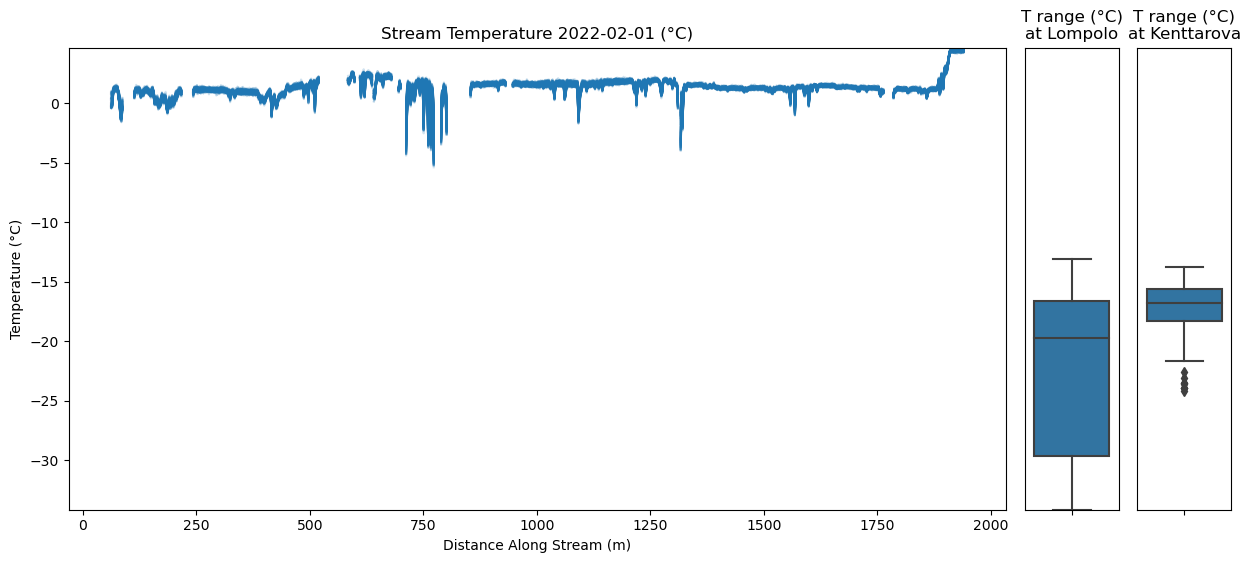

In [83]:
time_slice = slice('2022-02-01', '2022-02-02')
x_slice = slice(0, 2000)

plot_dts_meteo_distributions(xr_data=f_data_4, meteo_df=meteo1, time_slice=time_slice, x_slice=x_slice, save_fp=None)

In [76]:
f_data_5 = f_data_4.copy(deep=True)

remove = 'sections'

if remove == 'sections':
    # Compute the minimum along 'time' for each x location
    min_values = f_data_4["T"].min(dim="time")
    
    # Build a mask of x locations where the minimum is below 0
    mask = min_values < 0  # shape: (x,)
    
    # Expand this mask to align with (time, x) shape of 'T'
    mask_broadcasted = mask.broadcast_like(f_data_5["T"])
    
    # Apply the mask
    f_data_5["T"] = f_data_5["T"].where(~mask_broadcasted)
    
elif remove == 'points':
    f_data_5['T'] = f_data_5['T'].where(f_data_4['T'] >= 0, np.nan)

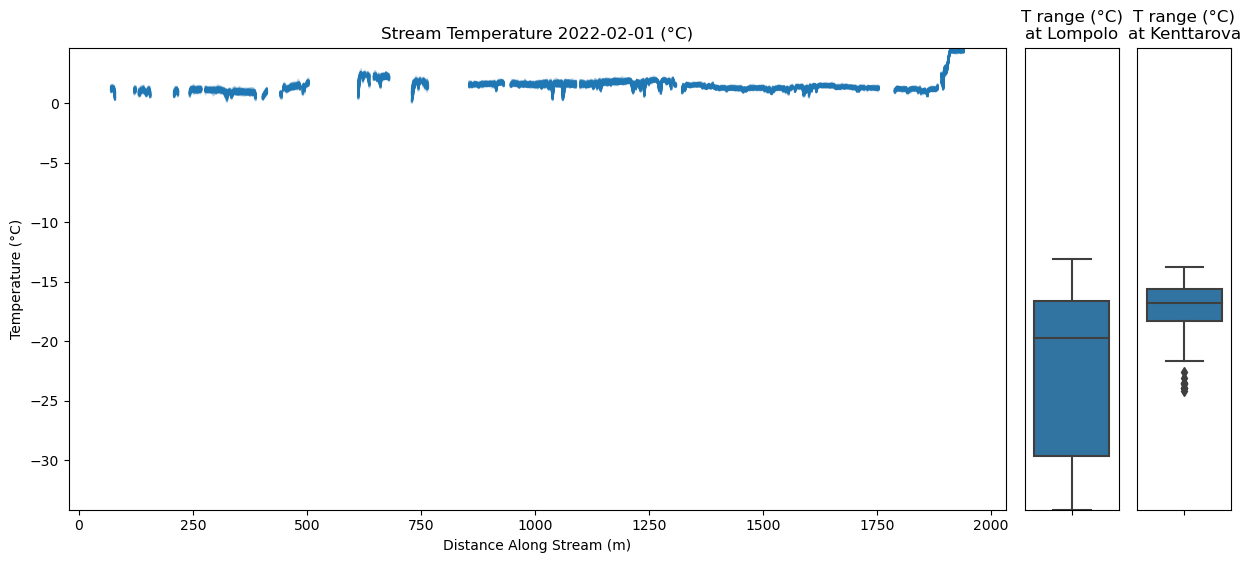

In [84]:
time_slice = slice('2022-02-01', '2022-02-02')
x_slice = slice(0, 2000)

plot_dts_meteo_distributions(xr_data=f_data_5, meteo_df=meteo1, time_slice=time_slice, x_slice=x_slice, save_fp=None)

In [94]:
out_fp = r'/Users/jpnousu/DTS_data/PROCESSED_DATA/pallas_dts_data_f_5.nc'
f_data_5.to_netcdf(out_fp)

#### Checking time just after snowmelt (see visu_tests.ipynb)

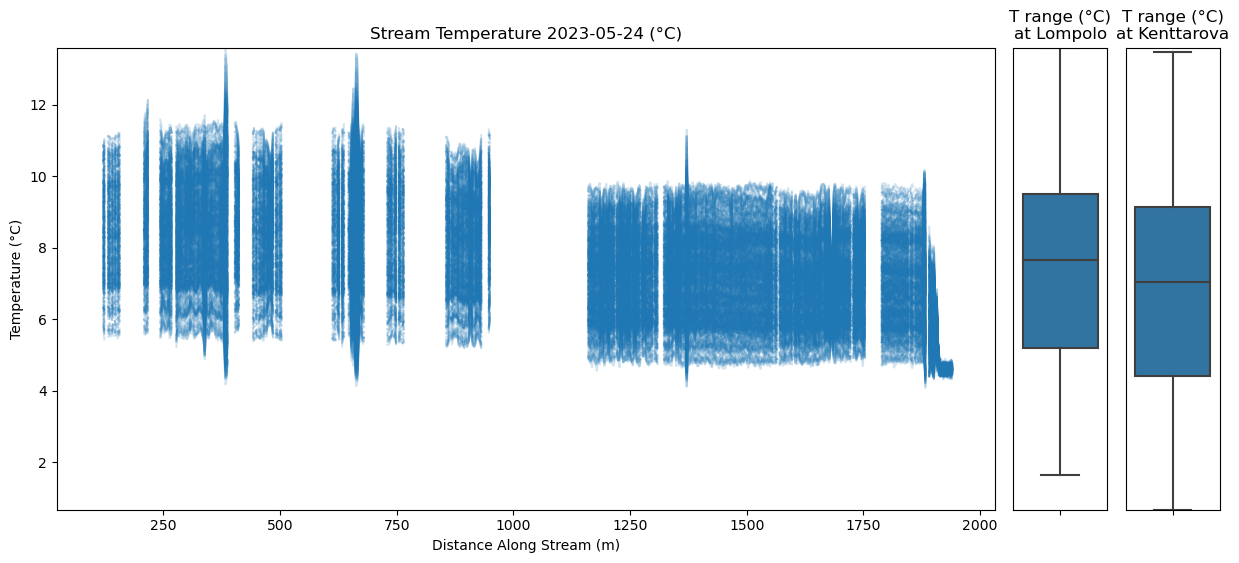

In [86]:
time_slice = slice('2023-05-24', '2023-05-31')
x_slice = slice(0, 2000)

plot_dts_meteo_distributions(xr_data=f_data_5, meteo_df=meteo1, time_slice=time_slice, x_slice=x_slice, save_fp=None)

#### --> There are some sections where high temperature reaches air temperature

#### Checking time just before snow (see visu_tests.ipynb)

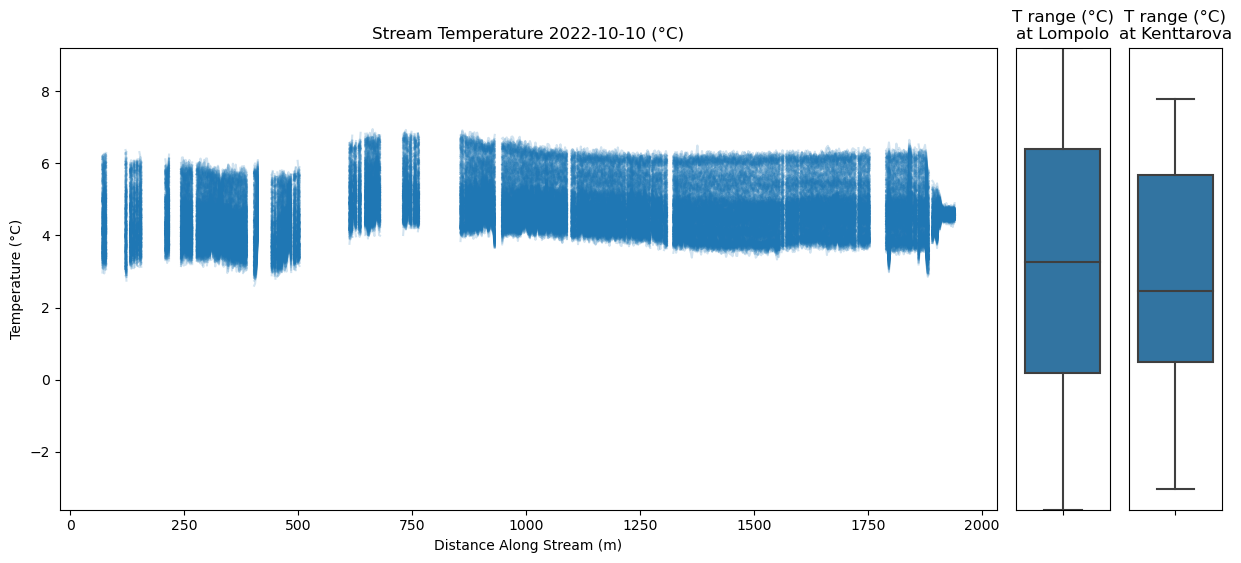

In [92]:
time_slice = slice('2022-10-10', '2022-10-15')
x_slice = slice(0, 2000)

plot_dts_meteo_distributions(xr_data=f_data_5, meteo_df=meteo1, time_slice=time_slice, x_slice=x_slice, save_fp=None)

#### Seems realistic, air temperature drops negative but stream sections stay above +2C

#### Let's go back to the time after snowmelt with some 'too hot' sections
##### Plotting minimums and maximums (range) for each x and the air temperature data

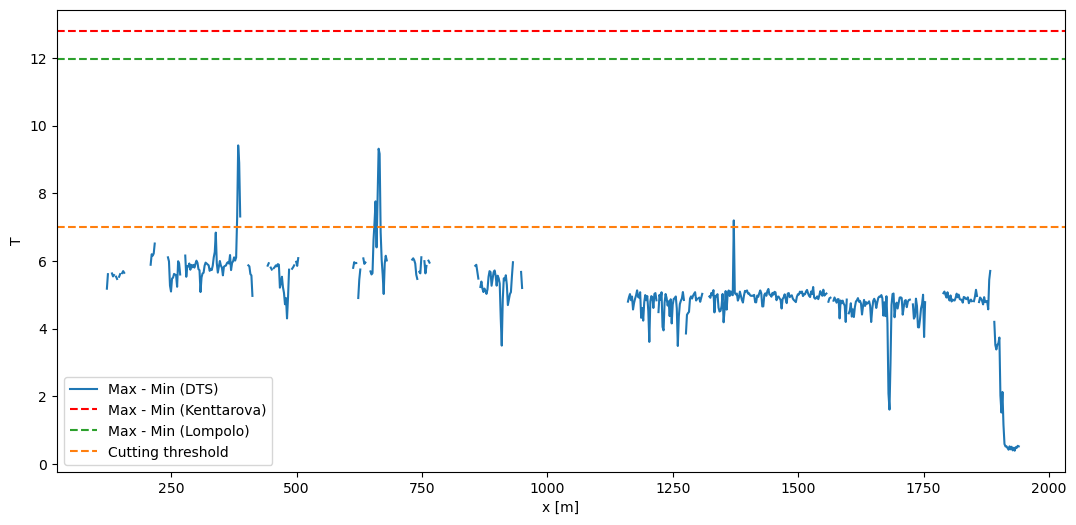

In [71]:
time_slice = slice('2023-05-24', '2023-05-31')
cut = 7.
plt.figure(figsize=(13, 6))

(f_data_5.sel(time=time_slice)['T'].max(dim='time') - f_data_5.sel(time=time_slice)['T'].min(dim='time')).plot(label='Max - Min (DTS)')
temp_dif_kenttarova = meteo1.loc[time_slice, 'Kenttarova'].max() - meteo1.loc[time_slice, 'Kenttarova'].min()
temp_dif_lompolo = meteo1.loc[time_slice, 'Lompolo'].max() - meteo1.loc[time_slice, 'Lompolo'].min()
plt.axhline(y=temp_dif_kenttarova, color='red', linestyle='--', label='Max - Min (Kenttarova)')
plt.axhline(y=temp_dif_lompolo, color='tab:green', linestyle='--', label='Max - Min (Lompolo)')

plt.axhline(y=cut, color='tab:orange', linestyle='--', label='Cutting threshold')

plt.legend()

In [72]:
f_data_6 = f_data_5.copy(deep=True)
remove = 'maxmin'
# remove = 'std'
cut = 7.  # example threshold

if remove == 'maxmin':
    # Select the time slice for T
    T_slice = f_data_6['T'].sel(time=time_slice)

    # Compute the max-min difference along 'time' for each 'x'
    hot_x_mask = (T_slice.max(dim='time') - T_slice.min(dim='time')) > cut  # shape: (x,)

    # Expand the mask to the shape of the full T variable
    hot_x_mask_expanded = hot_x_mask.broadcast_like(f_data_6['T'])

    # Mask the original data
    f_data_6['T'] = f_data_6['T'].where(~hot_x_mask_expanded)

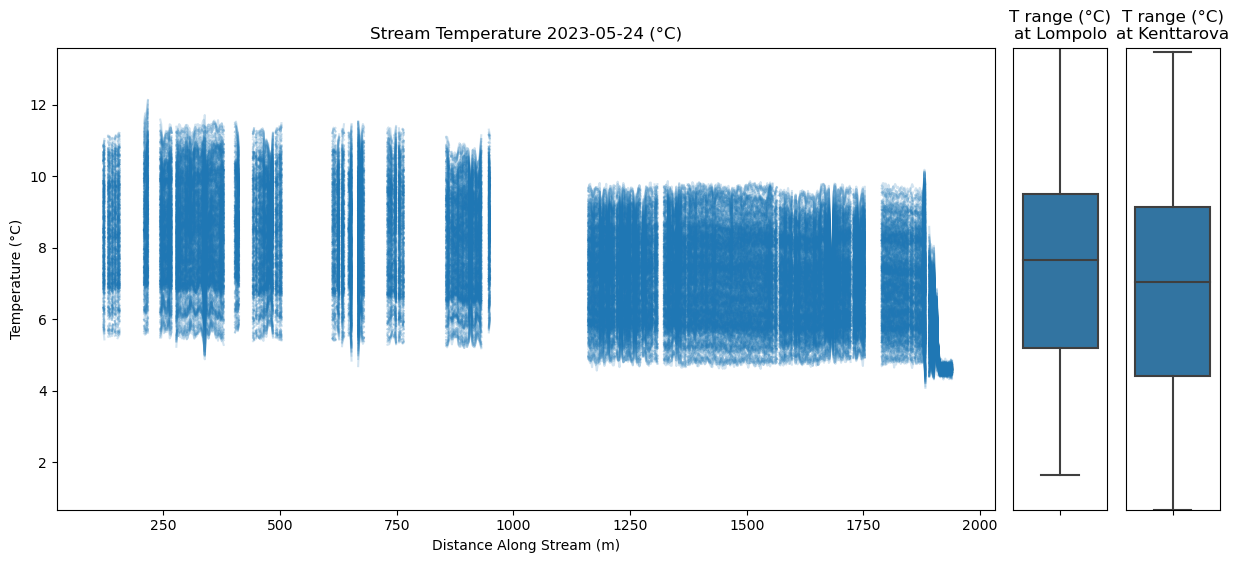

In [73]:
time_slice = slice('2023-05-24', '2023-05-31')
x_slice = slice(0, 2000)

plot_dts_meteo_distributions(xr_data=f_data_6, meteo_df=meteo1, time_slice=time_slice, x_slice=x_slice, save_fp=None)

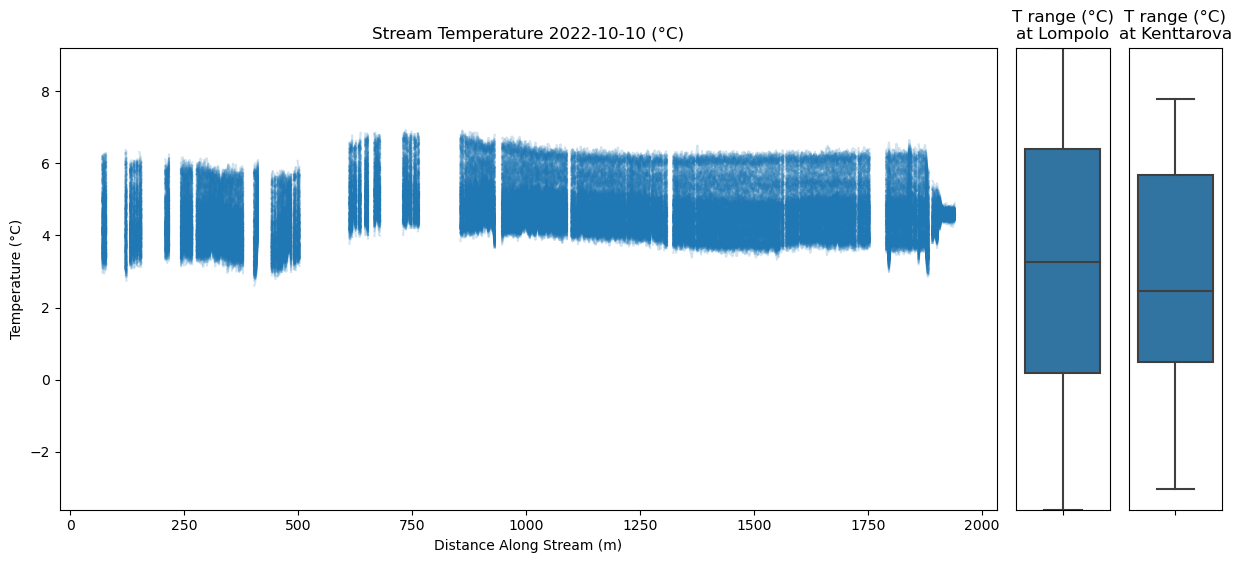

In [79]:
time_slice = slice('2022-10-10', '2022-10-15')
x_slice = slice(0, 2000)

plot_dts_meteo_distributions(xr_data=f_data_6, meteo_df=meteo1, time_slice=time_slice, x_slice=x_slice, save_fp=None)

In [93]:
out_fp = r'/Users/jpnousu/DTS_data/PROCESSED_DATA/pallas_dts_data_f_6.nc'
f_data_6.to_netcdf(out_fp)

#### Then by comparing the daily histograms
#### IF NECESSARY?

In [216]:
# Prepare empty DataFrame to store results
hm_df_d = pd.DataFrame(index=daily_dates_str, columns=x_all, dtype=float)

# Loop through dates and x values
for date_temp in daily_dates_str:
    for x_temp in x_all:
        try:
            # Extract data
            T_array = f_data_5.sel(time=date_temp, x=x_temp)['T'].values
            meteo_value = meteo1.loc[date_temp, 'Kenttarova']

            # Convert to arrays
            T_array = np.atleast_1d(T_array).flatten()
            meteo_array = np.full_like(T_array, meteo_value)  # broadcast scalar to array

            # Create synchronized finite mask
            valid_mask = np.isfinite(T_array) & np.isfinite(meteo_array)
            T_clean = T_array[valid_mask]
            meteo_clean = meteo_array[valid_mask]

            if T_clean.size == 0:
                continue

            # Define common histogram limits
            lims = [min(np.min(T_clean), np.min(meteo_clean)),
                    max(np.max(T_clean), np.max(meteo_clean))]

            # Calculate histogram match
            hm_temp = histogram_match(T_clean, meteo_clean, lims=lims)

            # Store result
            hm_df_d.at[date_temp, x_temp] = hm_temp

        except Exception:
            continue

<Axes: >

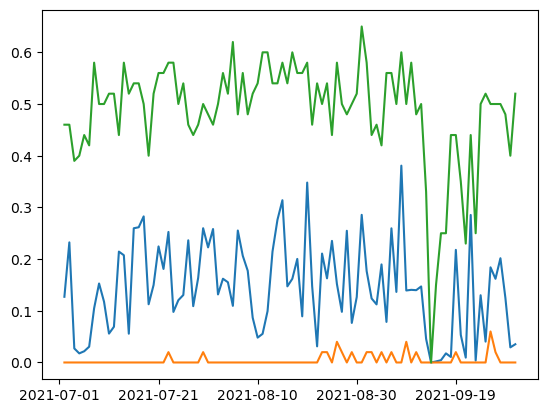

In [227]:
hm_df_d['2021-07-01':'2021-10-01'].mean(axis=1).plot()
hm_df_d['2021-07-01':'2021-10-01'].min(axis=1).plot()
hm_df_d['2021-07-01':'2021-10-01'].max(axis=1).plot()

In [228]:
hm_df_d

60.603    62.633    64.662    66.691    68.720    70.749    \
2021-07-01       NaN       NaN       NaN       NaN       NaN       NaN   
2021-07-02       NaN      0.38      0.27      0.25      0.27      0.29   
2021-07-03       NaN      0.17      0.15      0.17      0.27      0.19   
2021-07-04       NaN      0.10      0.04      0.04      0.12      0.04   
2021-07-05       NaN      0.00      0.00      0.00      0.00      0.00   
...              ...       ...       ...       ...       ...       ...   
2024-08-28       NaN      0.12      0.12      0.12      0.15      0.15   
2024-08-29       NaN      0.12      0.12      0.06      0.12      0.12   
2024-08-30       NaN      0.15      0.12      0.08      0.08      0.10   
2024-08-31       NaN      0.19      0.15      0.12      0.15      0.15   
2024-09-01       NaN      0.10      0.12      0.10      0.15      0.15   

            72.778    74.808    76.837    78.866    ...  1921.370  1923.399  \
2021-07-01       NaN       NaN       NaN       NaN  ...       NaN       NaN   
2021-07-02      0.21      0.25      0.23      0.23  ...       0.0       0.0   
2021-07-03      0.12      0.15      0.17      0.17  ...       0.0       0.0   
2021-07-04      0.02      0.04      0.02      0.04  ...       0.0       0.0   
2021-07-05      0.00      0.00      0.00      0.00  ...       0.0       0.0   
...              ...       ...       ...       ...  ...       ...       ...   
2024-08-28      0.12      0.08      0.15      0.15  ...       0.0       0.0   
2024-08-29      0.04      0.08      0.12      0.12  ...       0.0       0.0   
2024-08-30      0.08      0.08      0.10      0.10  ...       0.0       0.0   
2024-08-31      0.10      0.08      0.19      0.19  ...       0.0       0.0   
2024-09-01      0.10      0.12      0.12      0.12  ...       0.0       0.0   

            1925.429  1927.458  1929.487  1931.516  1933.545  1935.574  \
2021-07-01       NaN       NaN       NaN       NaN       NaN       NaN   
2021-07-02       0.0       0.0       0.0       0.0       0.0       0.0   
2021-07-03       0.0       0.0       0.0       0.0       0.0       0.0   
2021-07-04       0.0       0.0       0.0       0.0       0.0       0.0   
2021-07-05       0.0       0.0       0.0       0.0       0.0       0.0   
...              ...       ...       ...       ...       ...       ...   
2024-08-28       0.0       0.0       0.0       0.0       0.0       0.0   
2024-08-29       0.0       0.0       0.0       0.0       0.0       0.0   
2024-08-30       0.0       0.0       0.0       0.0       0.0       0.0   
2024-08-31       0.0       0.0       0.0       0.0       0.0       0.0   
2024-09-01       0.0       0.0       0.0       0.0       0.0       0.0   

            1937.604  1939.633  
2021-07-01       NaN       NaN  
2021-07-02       0.0       0.0  
2021-07-03       0.0       0.0  
2021-07-04       0.0       0.0  
2021-07-05       0.0       0.0  
...              ...       ...  
2024-08-28       0.0       0.0  
2024-08-29       0.0       0.0  
2024-08-30       0.0       0.0  
2024-08-31       0.0       0.0  
2024-09-01       0.0       0.0  

[1159 rows x 927 columns]

#### Then by comparing the monthly histograms

In [211]:
# Create a monthly index from the meteo1 index (month-starts)
monthly_index = pd.date_range(meteo1.index[0], meteo1.index[-1], freq='MS')
monthly_index_str = monthly_index.strftime('%Y-%m')

x_all = f_data_5['x'].values

# Prepare an empty DataFrame to store the histogram match values
hm_df_m = pd.DataFrame(index=monthly_index_str, columns=x_all, dtype=float)

# Loop over each month
for m_str in monthly_index_str:
    # Define start and end of the month
    start_date = pd.to_datetime(m_str + '-01')
    end_date = start_date + pd.offsets.MonthEnd(0)

    # Select data for the month
    f_data_month = f_data_5.sel(time=slice(start_date, end_date))
    meteo_array = meteo1.loc[start_date:end_date, 'Kenttarova'].values

    for x_temp in x_all:
        try:
            # Extract the temperature array for the current location
            T_array = f_data_month.sel(x=x_temp)['T'].values

            # Skip if either is missing or empty
            if T_array.size == 0 or meteo_array.size == 0:
                continue

            # Remove NaNs by synchronizing both arrays
            valid_mask = np.isfinite(T_array) & np.isfinite(meteo_array)
            T_clean = T_array[valid_mask]
            meteo_clean = meteo_array[valid_mask]

            # Skip if after cleaning any array becomes empty
            if T_clean.size == 0 or meteo_clean.size == 0:
                continue

            # Define common histogram limits
            lims = [min(np.min(T_clean), np.min(meteo_clean)),
                    max(np.max(T_clean), np.max(meteo_clean))]

            # Calculate histogram match
            hm_temp = histogram_match(T_clean, meteo_clean, lims=lims)

            # Store result
            hm_df_m.at[m_str, x_temp] = hm_temp

        except Exception:
            continue

<Axes: >

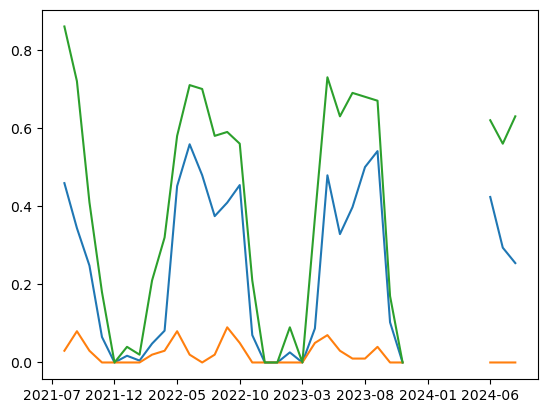

In [213]:
#hm_df_m.plot(legend=False)
hm_df_m.mean(axis=1).plot(legend=False)
hm_df_m.min(axis=1).plot(legend=False)
hm_df_m.max(axis=1).plot(legend=False)

#### Then by comparing the summer monthly histograms

In [214]:
# Create a monthly index and filter only summer months (June, July, August, September)
monthly_index = pd.date_range(meteo1.index[0], meteo1.index[-1], freq='MS')
monthly_index = [d for d in monthly_index if d.month in [6, 7, 8, 9]]
monthly_index_str = [d.strftime('%Y-%m') for d in monthly_index]

x_all = f_data_5['x'].values

# Prepare an empty DataFrame to store histogram match values
hm_df_ms = pd.DataFrame(index=monthly_index_str, columns=x_all, dtype=float)

# Loop over summer months
for m_str, m_start in zip(monthly_index_str, monthly_index):
    m_end = m_start + pd.offsets.MonthEnd(0)

    # Select data for the current month
    f_data_month = f_data_5.sel(time=slice(m_start, m_end))
    meteo_array = meteo1.loc[m_start:m_end, 'Kenttarova'].values

    for x_temp in x_all:
        try:
            # Extract temperature data for the current x location
            T_array = f_data_month.sel(x=x_temp)['T'].values

            # Skip if arrays are empty or contain no valid data
            if T_array.size == 0 or meteo_array.size == 0:
                continue

            # Remove NaNs from both T_array and meteo_array simultaneously
            valid_mask = np.isfinite(T_array) & np.isfinite(meteo_array)
            T_clean = T_array[valid_mask]
            meteo_clean = meteo_array[valid_mask]

            # Skip if, after cleaning, either array is empty
            if T_clean.size == 0 or meteo_clean.size == 0:
                continue

            # Define common histogram limits based on the cleaned data
            lims = [min(np.min(T_clean), np.min(meteo_clean)),
                    max(np.max(T_clean), np.max(meteo_clean))]

            # Compute histogram match
            hm_temp = histogram_match(T_clean, meteo_clean, lims=lims)

            # Store the result in the DataFrame
            hm_df_ms.at[m_str, x_temp] = hm_temp

        except Exception as e:
            # Handle exceptions (e.g., missing data or computation errors)
            print(f"Error for {m_str}, x={x_temp}: {e}")
            continue


<Axes: >

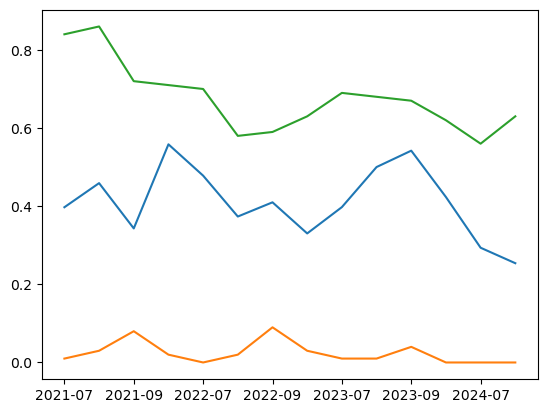

In [215]:
#hm_df_ms.plot(legend=False)
hm_df_ms.mean(axis=1).plot(legend=False)
hm_df_ms.min(axis=1).plot(legend=False)
hm_df_ms.max(axis=1).plot(legend=False)

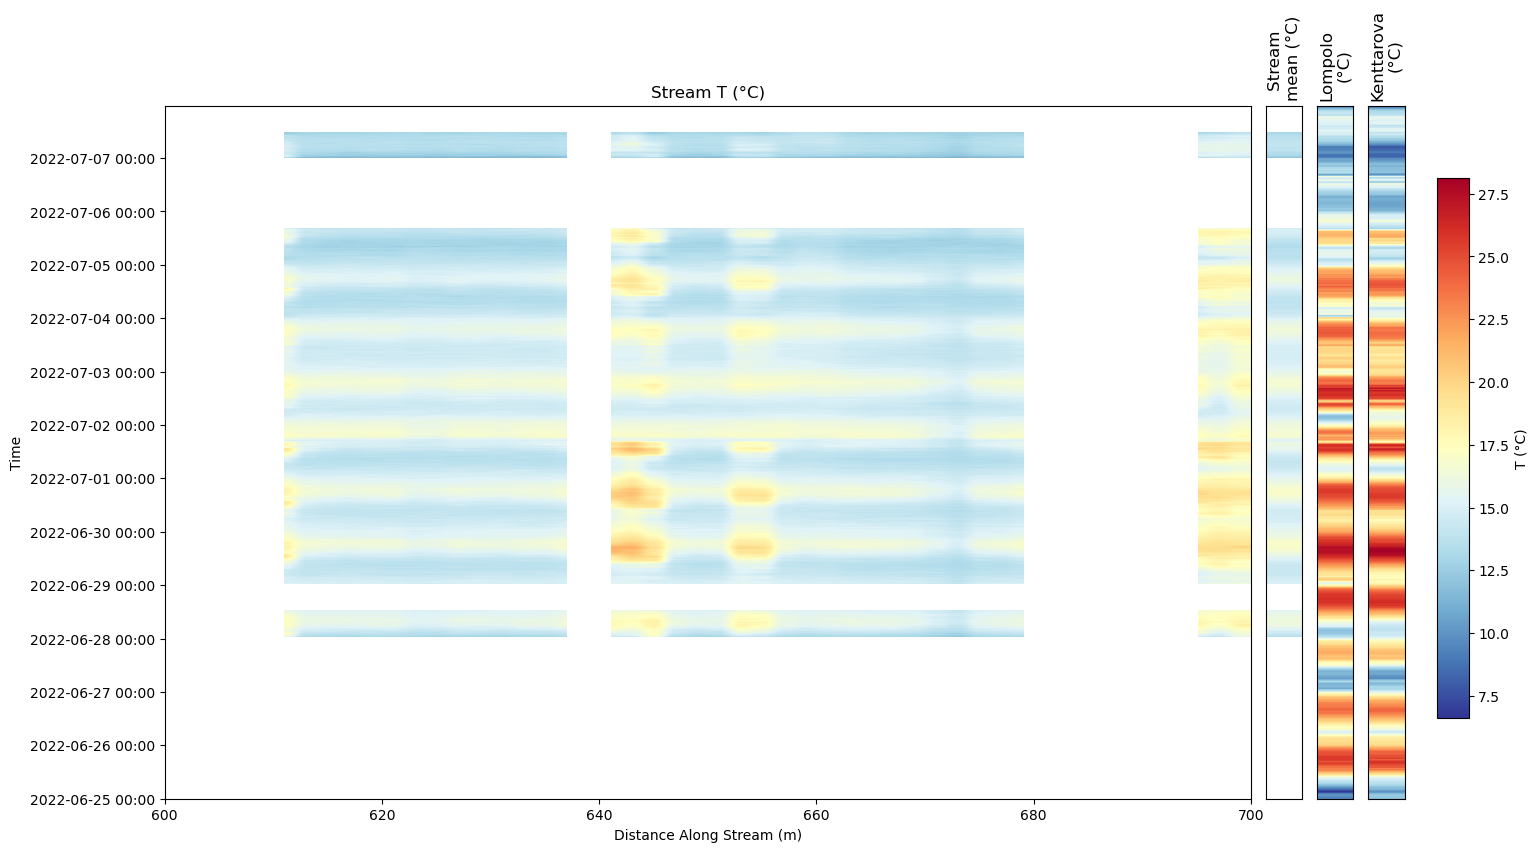

In [188]:
time_slice = slice('2022-06-25', '2022-07-07')
x_slice = slice(600, 700)
plot_2D_dts_colormap(xr_data=f_data_5, meteo_df=meteo1, time_slice=time_slice, x_slice=x_slice)

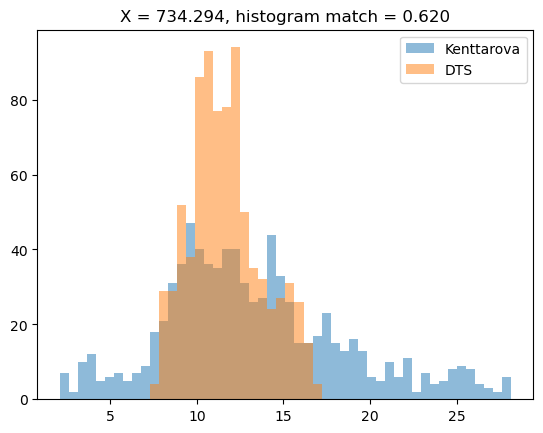

In [206]:
# Select the slice and location
time_slice = slice('2022-06-01', '2022-07-01')
x_temp = 734.294

# Extract data
T_array = f_data_5.sel(time=time_slice, x=x_temp)['T'].values
meteo_array = meteo1.loc[time_slice, 'Kenttarova'].values

# Ensure they are same length and align by time
min_len = min(len(T_array), len(meteo_array))
T_array = T_array[:min_len]
meteo_array = meteo_array[:min_len]

# Synchronized NaN removal
valid_mask = np.isfinite(T_array) & np.isfinite(meteo_array)
T_clean = T_array[valid_mask]
meteo_clean = meteo_array[valid_mask]

# Skip if either is empty after cleaning
if T_clean.size == 0 or meteo_clean.size == 0:
    print("No valid data available for this time slice and x.")
else:
    # Define number of bins
    nbins = 50

    # Create shared bins using common limits
    lims = [min(np.min(T_clean), np.min(meteo_clean)),
            max(np.max(T_clean), np.max(meteo_clean))]
    bins = np.linspace(lims[0], lims[1], nbins + 1)

    # Plot histograms
    plt.hist(meteo_clean, bins=bins, alpha=0.5, label='Kenttarova')
    plt.hist(T_clean, bins=bins, alpha=0.5, label='DTS')

    # Compute histogram match
    hm_temp = histogram_match(T_clean, meteo_clean, lims=lims)

    # Plot formatting
    plt.title(f'X = {x_temp}, histogram match = {hm_temp:.3f}')
    plt.legend()